<p style="font-size:11px;"><em><strong>Créditos</strong>: El contenido de este cuaderno ha sido tomado de varias fuentes, pero especialmente de <a href="http://darribas.org/">Dani Arribas-Bel</a> - University of Liverpool & <a href="http://spatial.ucr.edu/peopleRey.html">Sergio Rey</a> - Center for Geospatial Sciences, University of California, Riverside. El compilador se disculpa por cualquier omisión involuntaria y estaría encantado de agregar un reconocimiento.</em></p>

# Modelos de Regresión para Heterogeneidad Espacial

La heterogeneidad espacial es una característica fundamental de los datos geoespaciales y suponen importantes desafíos para los modelos estadísticos convencionales (\cite{anselin1988spatial, cressie2015statistics, lesage2009introduction}). La heterogeneidad espacial se refiere a la variabilidad de las condiciones del terreno a lo largo del espacio (\cite{anselin1990spatial}). Por ejemplo, las propiedades geomorfológicas de una ladera pueden diferir sustancialmente de las de otra dentro de una misma cuenca, afectando la susceptibilidad de cada zona a los movimientos en masa.  Ignorar esta heterogeneidad del espacio puede llevar a una subestimación o sobrestimación de la susceptibilidad en ciertas zonas del área de estudio.

Para abordar estas limitaciones, se han desarrollado modelos que permiten la variación espacial de los coeficientes de las variables predictoras, permitiendo capturar la heterogeneidad inherente al terreno (\cite{rey2023geographic}). Entre estos enfoques se encuentran los modelos multiniveles (\cite{wong1985hierarchical}) (también conocidos como jerárquicos, y en algunos casos modelos mixtos o regímenes espaciales) y los modelos de regresión espacial ponderada (GWR, por sus siglas en inglés) (\cite{brunsdon1996geographically}). Los modelos multiniveles permiten modelar la variabilidad espacial mediante la introducción de estructuras jerárquicas, asignando un coeficiente e intercepto para cada nivel o región incorporada en el modelo. Lo cual resulta particularmente útil cuando los datos presentan una organización natural en grupos o niveles (por ejemplo, cuencas y subcuencas). En contraste, los modelos GWR son menos complejos computacionalmente, ya que no requieren definir niveles jerárquicos. Los modelos GWR permiten que los coeficientes de las variables predictoras varíen para cada observación, proporcionando una caracterización más detallada de la influencia de las variables en función de su localización geográfica. Ambos enfoques presentan ventajas significativas frente a los modelos tradicionales, al capturar la variabilidad espacial, mejorando la precisión en la evaluación de la susceptibilidad a movimientos en masa.



## Regímenes Espaciales

En el siguiente ejemplo queremos conocer la relación que hay entre el número de carros y los niveles de contaminación en una ciudad. En el análisis inicial se desconoce en el análisis las comunas de la ciudad, en este caso Belén, Centro y el Poblado. Los resultados indican que a mayor número de carros menores valores de contaminación.

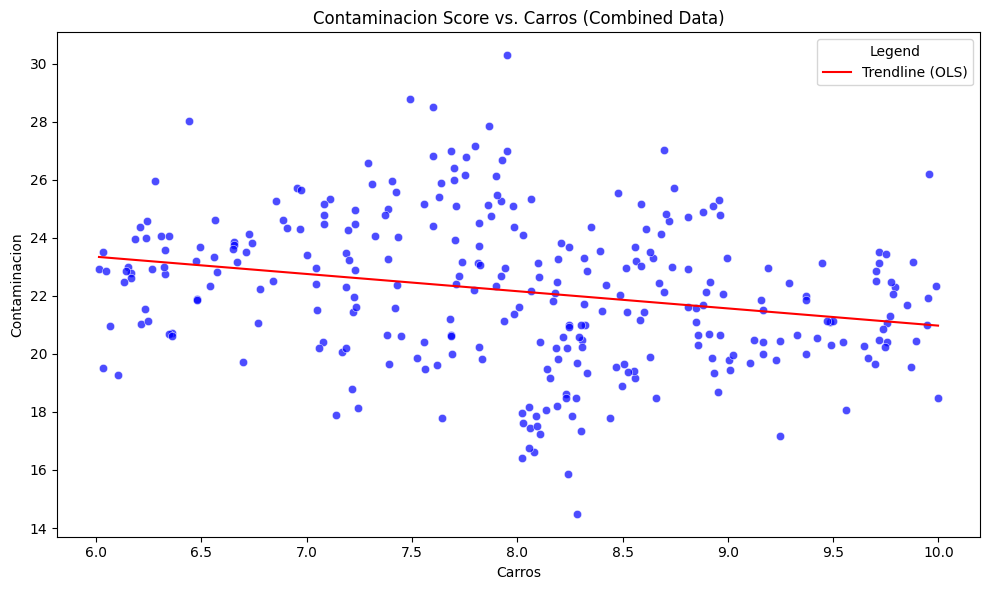

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data generation
group_a = pd.DataFrame({
    "Group": "Belen",
    "Carros": np.random.uniform(8, 10, 100),  
})
group_a["Contaminacion"] = 2 + (2 * group_a["Carros"]) + np.random.normal(0, 1.5, 100) 

group_b = pd.DataFrame({
    "Group": "Centro",
    "Carros": np.random.uniform(7, 9, 100),  
})
group_b["Contaminacion"] = 6 + (2 * group_b["Carros"]) + np.random.normal(0, 1.5, 100) 

group_c = pd.DataFrame({
    "Group": "Poblado",
    "Carros": np.random.uniform(6, 8, 100), 
})
group_c["Contaminacion"] = 10 + (2 * group_c["Carros"]) + np.random.normal(0, 1.5, 100) 

# Combine data
data = pd.concat([group_a, group_b, group_c], ignore_index=True)

# Create scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="Carros", y="Contaminacion", color="blue", alpha=0.7)

# Fit a single trendline for all data
X = data["Carros"]
y = data["Contaminacion"]
X = sm.add_constant(X)  # Add constant for intercept
model = sm.OLS(y, X).fit()

# Plot the trendline
trend_x = np.linspace(data["Carros"].min(), data["Carros"].max(), 100)
trend_y = model.predict(sm.add_constant(trend_x))
plt.plot(trend_x, trend_y, color="red", label="Trendline (OLS)")

# Customize plot
plt.title("Contaminacion Score vs. Carros (Combined Data)")
plt.xlabel("Carros")
plt.ylabel("Contaminacion")
plt.legend(title="Legend")
plt.tight_layout()
plt.show()

Pero si incorporamos en el análisis la variable comuna, lo que significa que cada comuna tiene sus condiciones particulares, y realizamos una regresión para cada grupo de datos, los resultados del análisis cambian completamente.

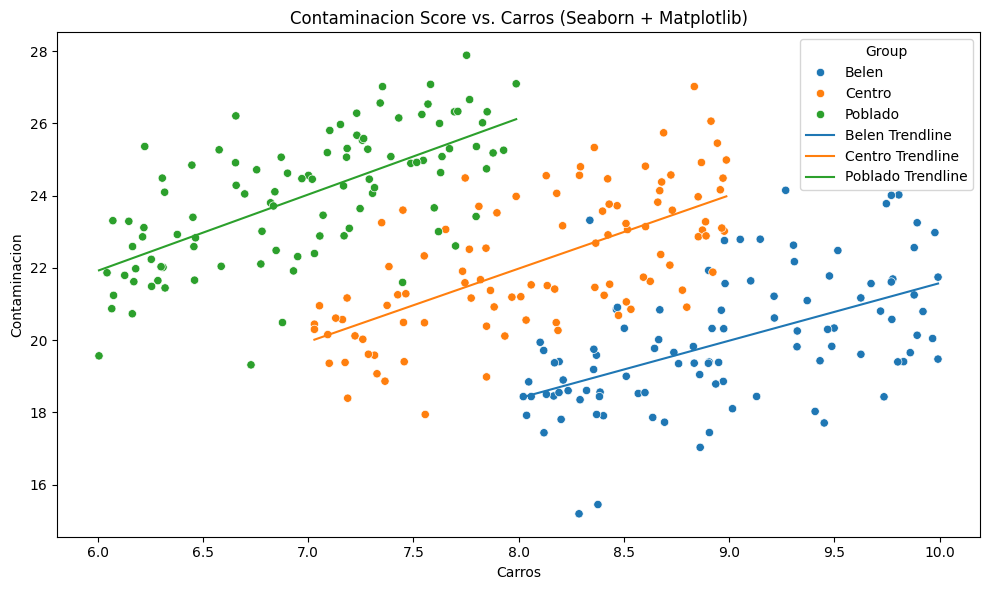

In [6]:
# Create scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="Carros", y="Contaminacion", hue="Group")

# Fit and plot separate trendlines for each group
groups = data["Group"].unique()
for group in groups:
    group_data = data[data["Group"] == group]
    X = group_data["Carros"]
    y = group_data["Contaminacion"]
    # Fit linear model
    X = sm.add_constant(X)  # Add constant for intercept
    model = sm.OLS(y, X).fit()
    # Plot the trendline
    trend_x = np.linspace(group_data["Carros"].min(), group_data["Carros"].max(), 100)
    trend_y = model.predict(sm.add_constant(trend_x))
    plt.plot(trend_x, trend_y, label=f"{group} Trendline")

# Customize plot
plt.title("Contaminacion Score vs. Carros (Seaborn + Matplotlib)")
plt.xlabel("Carros")
plt.ylabel("Contaminacion")
plt.legend(title="Group")
plt.tight_layout()
plt.show()

Cómo podemos entonces realizar uan regresión donde tome todos los datos y los elementos que comparten en común, pero que al mismo tiempo considere los cambios espaciales que hay por regiones.

### Intercepto variable (Efectos fijos espaciales)
Mientras asumimos que nuestra variable de proximidad podría representar un premium difícil de medir que las personas pagan cuando están cerca de una zona recreativa. Sin embargo, no todos los vecindarios son iguales; algunos vecindarios pueden ser más lucrativos que otros, independientemente de su proximidad a Balboa Park. Cuando este es el caso, necesitamos alguna forma de tener en cuenta el hecho de que cada vecindario puede experimentar estos tipos de efectos *gestalt*, únicos. Una forma de hacerlo es capturando la *heterogeneidad espacial*. En su forma más básica, la *heterogeneidad espacial* significa que partes del modelo pueden cambiar en diferentes lugares. Por ejemplo, los cambios en la intercepción, $\alpha$, pueden reflejar el hecho de que diferentes áreas tienen exposiciones basales diferentes a un proceso dado. Los cambios en los términos de pendiente, $\beta$, pueden indicar algún tipo de factor mediador geográfico, como cuando una política gubernamental no se aplica de manera consistente en todas las jurisdicciones. Finalmente, los cambios en la varianza de los residuos, comúnmente denotada como $\sigma^2$, pueden introducir heterocedasticidad espacial.

Para ilustrar los efectos fijos espaciales, consideremos el ejemplo del precio de las casas de la sección anterior para introducir una ilustración más general de "espacio como proxy". Dado que solo estamos incluyendo dos variables explicativas en el modelo, es probable que estemos omitiendo algunos factores importantes que juegan un papel en la determinación del precio al que se vende una casa. Algunos de ellos, sin embargo, es probable que varíen sistemáticamente en el espacio (por ejemplo, diferentes características del vecindario). Si ese es el caso, podemos controlar esos factores no observados utilizando variables dummy tradicionales pero basando su creación en una regla espacial. Por ejemplo, incluyamos una variable binaria para cada vecindario, indicando si una casa dada se encuentra dentro de dicho área (`1`) o no (`0`). Matemáticamente, ahora estamos ajustando la siguiente ecuación:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

donde la principal diferencia es que ahora estamos permitiendo que el término constante, $\alpha$, varíe por vecindario $r$, $\alpha_r$.

Programáticamente, mostraremos dos formas diferentes de estimar esto: uno, usando `statsmodels`; y dos, con `PySAL`. Primero, usaremos `statsmodels`. Este paquete proporciona una API similar a la de fórmulas, que nos permite expresar la *ecuación* que deseamos estimar directamente:

In [2]:
%matplotlib inline

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
db = gpd.read_file('https://geographicdata.science/book/_downloads/dcd429d1761a2d0efdbc4532e141ba14/regression_db.geojson')
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

<Axes: >

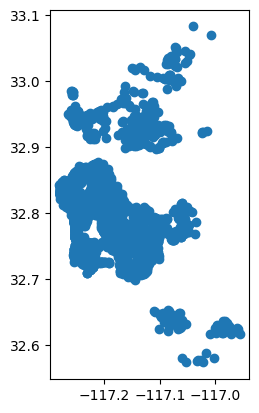

In [4]:
db.plot()

In [5]:
db.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)


Estas son las variables explicativas que utilizaremos a lo largo de este ejemplo.


In [6]:
variable_names = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'rt_Private_room', 'rt_Shared_room', 'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse']

El operador *tilde* en esta declaración suele leerse como "el precio logarítmico es una función de ...", para tener en cuenta el hecho de que se pueden ajustar muchas especificaciones de modelo diferentes según esa relación funcional entre `log_price` y nuestra lista de covariables. Es importante destacar que el término `-1` al final significa que estamos ajustando este modelo sin un término de intercepción. Esto es necesario, ya que incluir un término de intercepción junto con medias únicas para cada vecindario haría que el sistema subyacente de ecuaciones estuviera subespecificado.

Usando esta expresión, podemos estimar los efectos únicos de cada vecindario, ajustando el modelo en `statsmodels`:
 

In [28]:
m3 = sm.ols("log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1", data=db).fit()
print(m3.summary2())

                           Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.709    
Dependent Variable:         log_price              AIC:                      7229.6640
Date:                       2024-10-11 17:58       BIC:                      7599.1365
No. Observations:           6110                   Log-Likelihood:           -3559.8  
Df Model:                   54                     F-statistic:              276.9    
Df Residuals:               6055                   Prob (F-statistic):       0.00     
R-squared:                  0.712                  Scale:                    0.18946  
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------
neighborhood[Balboa Park]              4.2808   0.0333 128.5836 0.0000 

El enfoque anterior muestra cómo los Efectos Fijos Espaciales (FE) son un caso particular de una regresión lineal con una variable categórica. La pertenencia al vecindario se modela utilizando variables ficticias binarias. Gracias a la gramática de fórmulas utilizada en `statsmodels`, podemos expresar el modelo de manera abstracta, y Python lo analiza, creando apropiadamente variables binarias según sea necesario.

El segundo enfoque aprovecha la funcionalidad de Regímenes de `PySAL`, que permite al usuario especificar qué variables se estiman por separado para cada "régimen". Sin embargo, en este caso, en lugar de describir el modelo en una fórmula, necesitamos pasar cada elemento del modelo como argumentos separados.


In [29]:
# PySAL implementation
m4 = spreg.OLS_Regimes(db[['log_price']].values, db[variable_names].values,
                       db['neighborhood'].tolist(),
                       constant_regi='many', cols2regi=[False]*len(variable_names),
                       regime_err_sep=False,
                       name_y='log_price', name_x=variable_names)
print(m4.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6055
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:     1147.17                F-statistic           :    276.9408
Sigma-square        :       0.189                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3559.832
Sigma-square ML     :       0.188                Akaike info criterion :    7229.664
S.E of regression ML:      0.4333                Schwarz criterion     :    7599.137

----------------------------------------

Hablando económicamente, lo que implican los Efectos Fijos de Vecindario que hemos introducido es que, en lugar de comparar todos los precios de las casas en San Diego como iguales, solo derivamos variación dentro de cada código postal. Recuerda que la interpretación de $\beta_k$ es el efecto de la variable $k$, *dado que todas las demás variables explicativas incluidas permanecen constantes*. Al incluir una sola variable para cada área, estamos forzando efectivamente al modelo a comparar como iguales solo los precios de las casas que comparten el mismo valor para cada variable; o, en otras palabras, solo las casas ubicadas dentro de la misma área. La introducción de los Efectos Fijos permite un mayor grado de aislamiento de los efectos de las variables que introducimos en el modelo porque podemos controlar los efectos no observados que se alinean espacialmente con la distribución de los Efectos Fijos introducidos (por código postal, en nuestro caso).

Para hacer un mapa de los Efectos Fijos de Vecindario, necesitamos procesar ligeramente los resultados de nuestro modelo.

Primero, extraemos solo los efectos pertinentes a los vecindarios:


In [30]:
neighborhood_effects = m3.params.filter(like='neighborhood')
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

Después, necesitamos extraer solo el nombre del vecindario del índice de esta Serie. Una forma sencilla de hacerlo es eliminar todos los caracteres que están antes y después de nuestros nombres de vecindario:

Ahora, podemos volver a unirlos con las formas de los vecindarios:


In [31]:
stripped = neighborhood_effects.index.str.strip('neighborhood[').str.strip(']')
neighborhood_effects.index = stripped
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


In [36]:
import requests
url = 'http://data.insideairbnb.com/united-states/'\
      'ca/san-diego/2016-07-07/visualisations/'\
      'neighbourhoods.geojson'
r = requests.get(url)
with open('neighbourhoods.geojson', 'wb') as fo:
    fo.write(r.content)

In [47]:
neighborhoods = gpd.read_file('output.geojson')

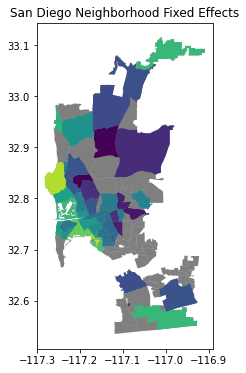

In [ ]:
ax = neighborhoods.plot(color='k', 
                        alpha=0.5,
                        figsize=(12,6))
neighborhoods.merge(neighborhood_effects, how='left',
                    left_on='neighbourhood', 
                    right_index=True)\
                  .dropna(subset=['fixed_effect'])\
                  .plot('fixed_effect',
                        ax=ax)
ax.set_title("San Diego Neighborhood Fixed Effects")
plt.show()

### Intercepto y coeficientes variables

En el núcleo de la estimación de efectos fijos espaciales está la idea de que, en lugar de asumir que la variable dependiente se comporta uniformemente en el espacio, existen efectos sistemáticos que siguen un patrón geográfico y afectan su comportamiento. En otras palabras, **los efectos fijos espaciales introducen econometricamente la noción de heterogeneidad espacial**. Lo hacen en la forma más simple posible: al permitir que el término constante varíe geográficamente. Los demás elementos de la regresión permanecen sin cambios y, por lo tanto, se aplican uniformemente en todo el espacio. **La idea de los regímenes espaciales (RE) es generalizar el enfoque de los efectos fijos espaciales para permitir que no solo el término constante varíe, sino también cualquier otra variable explicativa**. Esto implica que la ecuación que estaremos estimando es:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

donde no solo permitimos que el término constante varíe por región ($\alpha_r$), sino también cada otro parámetro ($\beta_{k-r}$).

Para ilustrar este enfoque, usaremos el "diferenciador espacial" de si una casa está en un vecindario costero o no (`coastal_neig`) para definir los regímenes. La razón detrás de esta elección es que alquilar una casa cerca del océano podría ser un factor lo suficientemente fuerte como para que las personas estén dispuestas a pagar a diferentes *tasas* por cada una de las características de la casa.

Para implementar esto en Python, usamos la clase `OLS_Regimes` en `PySAL`, que hace la mayor parte del trabajo pesado por nosotros:


In [48]:
m4 = spreg.OLS_Regimes(db[['log_price']].values, db[variable_names].values,
                          db['coastal'].tolist(),
                          constant_regi='many',
                          regime_err_sep=False,
                          name_y='log_price', name_x=variable_names)
print(m4.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          22
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6088
R-squared           :      0.6853
Adjusted R-squared  :      0.6843
Sum squared residual:     1252.49                F-statistic           :    631.4283
Sigma-square        :       0.206                Prob(F-statistic)     :           0
S.E. of regression  :       0.454                Log likelihood        :   -3828.169
Sigma-square ML     :       0.205                Akaike info criterion :    7700.339
S.E of regression ML:      0.4528                Schwarz criterion     :    7848.128

----------------------------------------

## Modelos jerarquicos con R

```r
#importar librerias
library(sf) #para importar datos geoespaciales
library(lme4) # para el modelo
library(pscl) # para calcular los R2
library(MuMIn) #para calcular los R2 en el modelo multinivel 
library(ggplot2) # Plotting library
library(ggspatial) # For adding north arrow and scale to maps
library(broom.mixed) # para transformar tabla
library(kableExtra) #para crear tabla en LaTEX
library(sjPlot) #para graficar los effectos
library(knitr) #para LaTEX table
library(broom)
library(dplyr) # for data manipulation
library(grid) #to export the table
library(pROC) # for the ROC curve

#Cargar datos
data = st_read("https://github.com/edieraristizabal/ModeloMultinivel/blob/main/DATA/df_catchments_spatial.gpkg")

# Create Y_bin as 1 if lands_rec is 1 or greater, otherwise 0
data$Y_bin <- ifelse(data$lands_rec >= 1, 1, 0)

# Convert 'cuenca' to a factor (categorical variable)
data$cuenca <- as.factor(data$cuenca)
data$kmeans <- as.factor(data$kmeans)

# Ensure predictor variables are standardized
data$elev_mean_std <- scale(data$elev_mean)
data$rel_mean_std <- scale(data$rel_mean)
data$area_std <- scale(data$area)
data$rainfallAnnual_mean_std <- scale(data$rainfallAnnual_mean)

#########################################

# Fit the logistic regression model without random effects
m1 <- glm(
  Y_bin ~ elev_mean_std + rel_mean_std + area_std + rainfallAnnual_mean_std,
  data = data, 
  family = binomial(link = "logit")
)

# Calculate pseudo-R^2 values
pseudo_r2 <- pR2(m1)

# Fitted values for model m3
data$m1fitted <- fitted(m1) 

# Extract model coefficients as a tidy data frame
model_summary <- tidy(m1) %>%
  select(term, estimate, std.error, statistic, p.value) %>%
  rename(
    Variables = term,
    Estimate = estimate,
    Std_Error = std.error,
    Z_value = statistic,
    P_value = p.value
  )

##############################################

# Fit the multilevel logistic regression model with random slopes for each predictor
m2 <- glmer(
  Y_bin ~ elev_mean_std + rel_mean_std + area_std + rainfallAnnual_mean_std + 
    (1 + elev_mean_std + rel_mean_std + area_std + rainfallAnnual_mean_std | cuenca),
  data = data,
  family = binomial(link = "logit"),
  control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5))
)

# Print the summary of the model to see the results
summary(m2)

# Fitted values for model m3
data$m2fitted <- fitted(m2) 

# Extract random effects from the model
ranef_data <- ranef(m2)$cuenca
```
